In [4]:
from probability_trees import MinCut, Critical, PTree
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Latex

## Experimental and Nonexperimental Data used to illustrate the estimation of PN, the probability that drug $x$ was responsible for a person’s death ($y$). 

In [5]:
data = pd.DataFrame({'do(TakeDrug)':[16, 984],
                     "do(NotTakeDrug)": [14,986],
                     "TakeDrug": [2, 998],
                     "NotTakeDrug": [28, 972]},index=['Deaths', 'Survival'])
data

,do(TakeDrug),do(NotTakeDrug),TakeDrug,NotTakeDrug
Deaths,16,14,2,28
Survival,984,986,998,972


## Model generating the experimental and observational data of equations(16 and 17).Zrepresents an unobserved confounder affecting both treatment (X) and outcome (Y).

In [6]:
P =     {'Syndrome': 28/2000,
         "Death|Syndrome": 1,
         "Death|TakeDrug,NoSyndrome": 28/1000,
         "Death|NotTakeDrug,NoSyndrome": 2/1000,
         "TakeDrug|NoSyndrome": 1000/(1000 + 972),
         "TakeDrug|Syndrome": 0}
def legal_liability(bvar):
    # bvar contains a dictionary of bound variables. 
    if 'Z' not in bvar:
        return prevalence_of_syndrome( P['Syndrome'] )
    if 'X' not in bvar:
        return take_drug_based_on_syndrome( bvar['Z'], P["TakeDrug|NoSyndrome"], P["TakeDrug|Syndrome"] )
    if 'Y' not in bvar:
        return patient_dies_if_syndrome_or_takes_drug( bvar['X'], 
                                                       bvar['Z'],
                                                       P["Death|NotTakeDrug,NoSyndrome"],
                                                       P["Death|TakeDrug,NoSyndrome"] )
    return None

def prevalence_of_syndrome( r ):
    return [(1-r, 'Z=NoSyndrome'),
            (r,   'Z=Syndrome')]
def take_drug_based_on_syndrome( Z, q1, q2 ):
    if Z == 'NoSyndrome':
        return [(1-q1,'X=NotTakeDrug'),
                (q1,  'X=TakeDrug')]
    else:
        return [(1-q2,'X=NotTakeDrug'),
                (q2,  'X=TakeDrug')]   
    
def patient_dies_if_syndrome_or_takes_drug( X, Z, p1, p2 ):
    if Z == 'Syndrome':
        return [(0, 'Y=Survival'),
                (1, 'Y=Death')]
    elif X== 'TakeDrug':
        return [(1-p2, 'Y=Survival'),
                (p2,   'Y=Death')]
    else:
        return [(1-p1, 'Y=Survival'),
                (p1,   'Y=Death')]


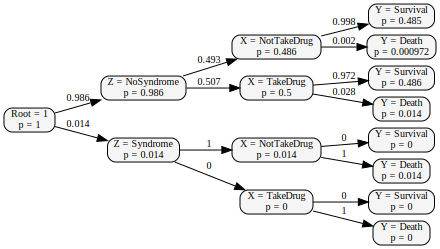

In [7]:
scm = PTree.fromFunc(legal_liability, 'Root=1')

display(scm.show(show_prob=True))


In [8]:
do_x1 = scm.do(scm.prop('X=TakeDrug'))
y1 = scm.prop('Y=Death')
P["Death|do(TakeDrug)"] = do_x1.prob(y1)
P

{'Syndrome': 0.014,
 'Death|Syndrome': 1,
 'Death|TakeDrug,NoSyndrome': 0.028,
 'Death|NotTakeDrug,NoSyndrome': 0.002,
 'TakeDrug|NoSyndrome': 0.5070993914807302,
 'TakeDrug|Syndrome': 0,
 'Death|do(TakeDrug)': 0.041608}

In [9]:
x1 = scm.prop('X=TakeDrug')
y1 = scm.prop('Y=Death')
y0 = scm.prop('Y=Survive')
given_x1_and_y1 = scm.see(x1 & y1)
what_if_x0 = scm.prop("X=NotTakeDrug")
PN = scm.cf(given_x1_and_y1, what_if_x0)
P["TakeDrug is Necessary Cause of Death"] = PN.prob(y0)
P

{'Syndrome': 0.014,
 'Death|Syndrome': 1,
 'Death|TakeDrug,NoSyndrome': 0.028,
 'Death|NotTakeDrug,NoSyndrome': 0.002,
 'TakeDrug|NoSyndrome': 0.5070993914807302,
 'TakeDrug|Syndrome': 0,
 'Death|do(TakeDrug)': 0.041608,
 'TakeDrug is Necessary Cause of Death': 0.0}